# More 3D UNets

This notebook vastly improves on the functionality of the t4 notebook. Much cleaner.

In [1]:
import monai
from monai.networks.nets import UNet
from monai.transforms import (
    Compose,
    LoadNiftid,
    ScaleIntensityd,
    NormalizeIntensityd,
    AddChanneld,
    ToTensord,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    CropForegroundd,
    Identityd,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [2]:
class UNet_DF(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        
        self.unet = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(64, 128, 258, 512, 1024),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
            dropout=0,
        )
        self.sample_masks = []
    
    # Data setup
    def setup(self, stage):
        data_dir = 'data/'
        
        # Train imgs/masks
        train_imgs = []
        with open(data_dir + 'train_imgs.txt', 'r') as f:
            train_imgs = [image.rstrip() for image in f.readlines()]

        train_masks = []
        with open(data_dir + 'train_masks.txt', 'r') as f:
            train_masks = [mask.rstrip() for mask in f.readlines()]
        
        train_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(train_imgs, train_masks)]
        
        train_dicts, val_dicts = train_test_split(train_dicts, test_size=0.2)
        
        # Basic transforms
        data_keys = ["image", "mask"]
        data_transforms = Compose(
            [
                LoadNiftid(keys=data_keys),
                AddChanneld(keys=data_keys),
                NormalizeIntensityd(keys="image"),
                RandCropByPosNegLabeld(
                    keys=data_keys,
                    label_key="mask",
                    spatial_size=self.hparams.patch_size,
                    num_samples=4,
                    image_key="image"
                ),
            ]
        )
        
        self.train_dataset = monai.data.CacheDataset(
            data=train_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
        self.val_dataset = monai.data.CacheDataset(
            data=val_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
    def train_dataloader(self):
        return monai.data.DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=hparams.num_workers
        )

    def val_dataloader(self):
        return monai.data.DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=hparams.num_workers
        )
    
    # Training setup
    def forward(self, image):
        return self.unet(image)
    
    def criterion(self, y_hat, y):
        dice_loss = monai.losses.DiceLoss(
            to_onehot_y=True,
            softmax=True
        )
        focal_loss = monai.losses.FocalLoss()
        return dice_loss(y_hat, y) + focal_loss(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch['image'], batch['mask']
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)

        self.logger.log_metrics({"loss/train": loss}, self.global_step)

        return {'loss': loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=lr)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        outputs = self(inputs)
        
        # Sample masks
        if self.current_epoch != 0:
            image = outputs[0].argmax(0)[:, :, 8].unsqueeze(0).detach()
            self.sample_masks.append(image)
        
        loss = self.criterion(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.logger.log_metrics({"val/loss": avg_loss}, self.current_epoch)
        
        if self.current_epoch != 0:
            grid = torchvision.utils.make_grid(self.sample_masks)
            self.logger.experiment.add_image('sample_masks', grid, self.current_epoch)
            self.sample_masks = []
        
        return {"val_loss": avg_loss}

In [12]:
from argparse import Namespace

args = {
    'name': '7-8-2020_dicefocal',
    'batch_size': 2,
    'lr': 0.001,
    'patch_size': [256, 256, 16],
    'num_workers': 6,
}

hparams = Namespace(**args)

In [15]:
model = UNet_DF(hparams)

In [2]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir models/7-8-2020_dicefocal/tb_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 24072), started 0:00:12 ago. (Use '!kill 24072' to kill it.)

In [16]:
NAME = 'models/' + hparams.name
logger = pl.loggers.TensorBoardLogger(NAME + "/tb_logs/", name='')

# Callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath=NAME + '/checkpoints/')


trainer = pl.Trainer(
    checkpoint_callback=checkpoint_callback,
    early_stop_callback=early_stopping,
    check_val_every_n_epoch=5,
    gpus=1,
    max_epochs=1000,
    logger=logger,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1]


115/115 Load and cache transformed data:  [==============================]
29/29 Load and cache transformed data:  [==============================]



  | Name | Type | Params
------------------------------
0 | unet | UNet | 31 M  


Process Process-27:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f23c9fc1430>
Traceback (most recent call last):
  File "/data3/johnkim/environments/env_pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/data3/johnkim/environments/env_pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 47, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.p

/data3/johnkim/environments/env_pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

## Evaluation

In [13]:
import os
import glob
import random
import matplotlib.pyplot as plt

In [17]:
print('models/' + hparams.name + '/*.ckpt')

models/7-8-2020_dicefocal/*.ckpt


In [19]:
model_ckpts = glob.glob('models/' + hparams.name + '/*.ckpt')
print(model_ckpts)
model = UNet_DF.load_from_checkpoint(model_ckpts[0])

['models/7-8-2020_dicefocal/_ckpt_epoch_119.ckpt']


In [20]:
def select_animals(images, masks, animals):
    """Returns the images and masks as a dictionary for specific animals."""
    filtered_images = []
    filtered_masks = []
    for animal in animals:
        filtered_images.extend(filter(lambda x: 'PSEA' + str(animal) in x, images))
        filtered_masks.extend(filter(lambda x: 'PSEA' + str(animal) in x, masks))
    return [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(filtered_images, filtered_masks)]

### Data collection
data_dir = 'data/'
print('Available directories: ', os.listdir(data_dir))

# Get paths for images and masks, organize into dictionaries
images = sorted(glob.glob(data_dir + '**/*CTImg*', recursive=True))
masks = sorted(glob.glob(data_dir + '**/*Mask*', recursive=True))
data_dicts = [{'image': image_file, 'mask': mask_file} for image_file, mask_file in zip(images, masks)]

test_dicts = select_animals(images, masks, [12])
data_keys = ['image', 'mask']

data_keys = ['image', 'mask']

test_transforms = Compose(
    [
        LoadNiftid(keys=data_keys),
        AddChanneld(keys=data_keys),
        NormalizeIntensityd(keys="image"),
        RandSpatialCropd(
            keys=data_keys,
            roi_size=(256, 256, 16),
            random_size=False
        ),
        ToTensord(keys=data_keys),
    ]
)

test_dataset = monai.data.Dataset(
    data=test_dicts,
    transform=test_transforms,
)

Available directories:  ['PSEA12 Baseline', 'PSEA13 PostGel', 'PSEA27 PostGel', 'PSEA25 Baseline', 'PSEA12 PostGel', 'test_masks.txt', '.ipynb_checkpoints', 'PSEA14 Baseline', 'train_imgs.txt', 'PSEA14 PostGel', 'PSEA20 PostMI', 'PSEA18 PostMI', 'PSEA12 PostMI', 'PSEA18 Baseline', 'PSEA27 PostMI', 'PSEA13 Baseline', 'PSEA20 PostGel', 'PSEA25 PostMI', 'PSEA27 Baseline', 'PSEA13 PostMI', 'test_imgs.txt', 'train_masks.txt', 'PSEA25 PostGel', 'PSEA18 PostGel']


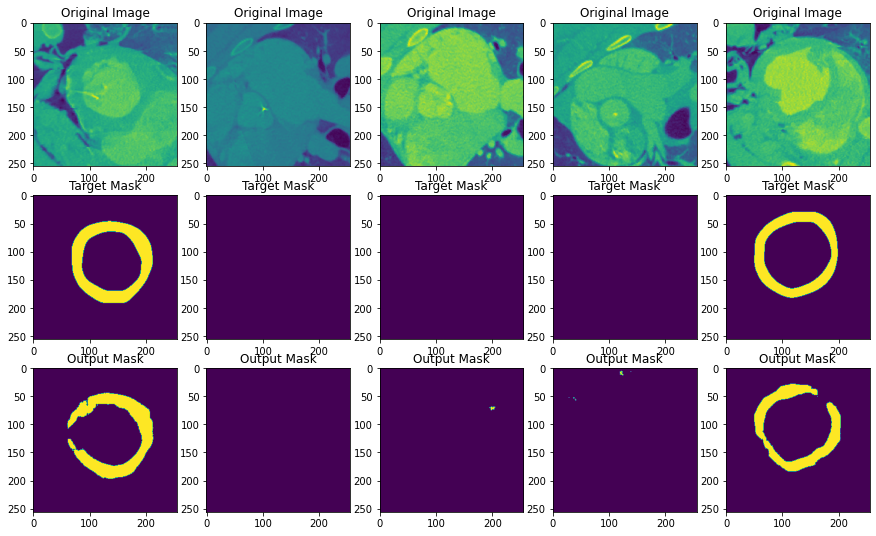

In [23]:
test_samples = random.sample(range(len(test_dataset)), 5)
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
slice_depth = 4
for i in range(5):
    sample = test_dataset[test_samples[i]]
    axs[0, i].imshow(sample['image'][0, :, :, slice_depth])
    axs[0, i].set_title('Original Image')

    axs[1, i].imshow(sample['mask'][0, :, :, slice_depth])
    axs[1, i].set_title('Target Mask')
    
    test_image = sample['image'].unsqueeze(0) #.squeeze(4)
    test_mask = model(test_image)
    test_mask = test_mask.argmax(1).squeeze(0).detach()
    axs[2, i].imshow(test_mask[:, :, slice_depth])
    axs[2, i].set_title('Output Mask')

plt.savefig('results/' + hparams.name + '.png')